In [1]:
# main function
import numpy as np
import torch
import matplotlib.pyplot as plt
import botorch

from xopt.bayesian.algorithms import bayesian_exploration
from xopt.bayesian.models.nan_enabled import NanEnabledModelListGP

from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

import os
SMOKE_TEST = os.environ.get('SMOKE_TEST')

# test function
from xopt.evaluators import test_TNK


In [2]:
"""
    Example where we must use a custom botorch model to make predictions. 
    We modify the test_TNK function with a wrapper to return Nan values for the y1 objective if one of the constraints are not satisfied.
    To accomidate this we define a ModelListGP model as a custom model to remove Nan values from the training data.

"""

# define a new test function that returns nans for y1 if c1 is not valid
def nan_test_TNK(x):
    outputs = test_TNK.evaluate_TNK(x)
    if outputs['c1'] < 0:
        outputs['y1'] = np.nan
        
    return outputs


# Get VOCS
VOCS = test_TNK.VOCS
VOCS['objectives'] = {'y1' : None}

# add reference point
ref = torch.tensor((1.4, 1.4))

print(VOCS)
# Get evaluate function
EVALUATE = nan_test_TNK

if 1:
    generator_options = {'batch_size': 1,
                           'num_restarts': 2,
                           'raw_samples': 2}
else:
    generator_options = {}

# Run
init_x = torch.tensor([[0.9, 0.9], [0.6, 0.6]])
results = bayesian_exploration(VOCS, EVALUATE,
                               custom_model = NanEnabledModelListGP,
                               n_initial_samples=5,
                               initial_x=None,
                               n_steps=15,
                               generator_options=generator_options,
                               verbose=True)

{'name': 'TNK_test', 'description': 'Constrainted test function TNK. See Table V in https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf', 'simulation': 'test_TNK', 'variables': {'x1': [0, 3.14159], 'x2': [0, 3.14159]}, 'objectives': {'y1': None}, 'constraints': {'c1': ['GREATER_THAN', 0], 'c2': ['LESS_THAN', 0.5]}, 'constants': {'a': 'dummy_constant'}}
started running optimization with generator: <xopt.bayesian.generators.exploration.BayesianExplorationGenerator object at 0x000001792CEBF250>
submitting initial candidates at time 2021-09-01T11:15:00-05:00
starting optimization loop
Model creation time: 0.218 s
Candidate generation time: 0.269 s
Candidate(s): tensor([[0.2696, 0.7141]], dtype=torch.float64)
submitting candidates at time 2021-09-01T11:15:00-05:00
Model creation time: 0.213 s
Candidate generation time: 0.2501 s
Candidate(s): tensor([[0.2715, 0.5879]], dtype=torch.float64)
submitting candidates at time 2021-09-01T11:15:01-05:00
Model creation time: 0.231 s
Candidate generation tim

dict_keys(['variables', 'objectives', 'corrected_objectives', 'constraints', 'corrected_constraints', 'constraint_status', 'feasibility', 'model'])
tensor([[1.9903],
        [   nan],
        [2.1875],
        [2.9715],
        [1.9559],
        [   nan],
        [   nan],
        [   nan],
        [0.2656],
        [   nan],
        [0.2639],
        [0.3806],
        [1.5629],
        [   nan],
        [   nan],
        [0.7478],
        [   nan],
        [1.0409],
        [0.6031],
        [1.0663]], dtype=torch.float64)


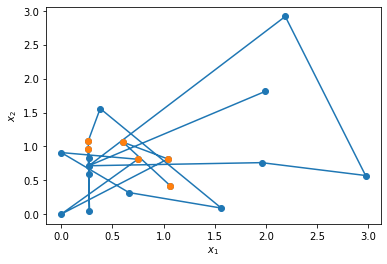

In [3]:
fig, ax = plt.subplots()
print(results.keys())
variables = results['variables']
print(results['objectives'])
valid = results['variables'][results['feasibility'].flatten()]
ax.plot(variables[:, 0], variables[:, 1], '-o')
ax.plot(valid[:, 0], valid[:, 1], 'o')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()